<a href="https://colab.research.google.com/github/1205apd/titanic/blob/main/titanic_final_commit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q sklearn

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython.display import clear_output
import tensorflow.compat.v2.feature_column as fc

from six.moves import urllib
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
dftrain=pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval=pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train=dftrain.pop('survived')
y_test=dfeval.pop('survived')

In [ ]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [ ]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck','embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [ ]:
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column  
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

In [ ]:
def make_input_fn(data_df, label_df, shuffle=True, num_epochs=10, batch_size=32):
  def input_function():
    ds=tf.data.Dataset.from_tensor_slices((dict(data_df),label_df))
    if shuffle:
      ds=ds.shuffle(1000)
    ds=ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

In [ ]:
train_input_fn=make_input_fn(dftrain,y_train)
eval_input_fn=make_input_fn(dfeval,y_test,num_epochs=1,shuffle=False)

In [ ]:
linear_est=tf.estimator.LinearClassifier(feature_columns=feature_columns)
clear_output()

In [ ]:
linear_est.train(train_input_fn)
result=linear_est.evaluate(eval_input_fn)
clear_output()
print(result['accuracy'])

0.75757575


In [ ]:
print(result)

{'accuracy': 0.75757575, 'accuracy_baseline': 0.625, 'auc': 0.83645546, 'auc_precision_recall': 0.7757952, 'average_loss': 0.4822599, 'label/mean': 0.375, 'loss': 0.47250515, 'precision': 0.6966292, 'prediction/mean': 0.32914352, 'recall': 0.6262626, 'global_step': 200}


In [ ]:
result=list(linear_est.predict(eval_input_fn))
clear_output()
print(dfeval.loc[6])
print(y_test.loc[6])
print(result[5]['probabilities'][0])

sex                        female
age                             8
n_siblings_spouses              3
parch                           1
fare                       21.075
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 6, dtype: object
0
0.3155184


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpzr6z5l9i/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


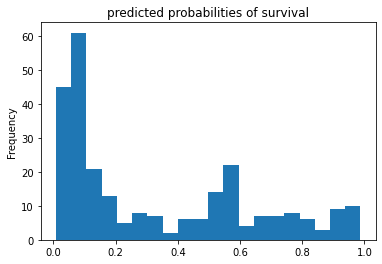

In [ ]:
pred_dict=list(linear_est.predict(eval_input_fn))
graphic=pd.Series([pred['probabilities'][1] for pred in pred_dict])
graphic.plot(kind='hist',bins=20,title='predicted probabilities of survival')

Text(0, 0.5, 'true positive rate')

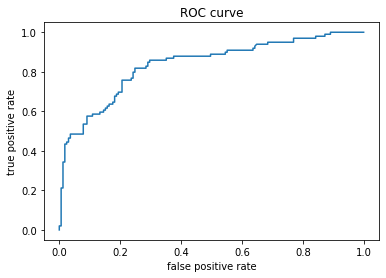

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr,tpr,_=roc_curve(y_test,graphic)
plt.plot(fpr,tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')